<h1 style="text-align: center;">Simulación y aplicaciones en ciencias sociales y experimentales
</h3>
<h3 style="text-align: center;"> Tema 3. Modelos aleatorios </h3>
<h3 style="text-align: center;"> Modelo de Colas (ejercicios propuestos) </h3>

### Ejercicio 

Se propone un ejercicio teórico-práctico. Consiste en idear un modelo para un sistema real aleatorio markoviano, con planteamiento libre. Se valorará positivamente que el ajuste o estimación de los parámetros o variables aleatorias iniciales a partir de muestreos o toma de datos reales. El objetivo del modelo es ayudar a través de las simulaciones a la toma de decisiones óptimas de gestión/utilización del sistema

Se dan dos ejemplos a modo de sugerencias, pero puede ser cualquier otro proceso markoviano similar a los estudiados. 

- Juego de azar sin memoria, en el que el conjunto de estados es finito (ganar, perder, empatar, etc.) y las probabilidades son fijas. A través del modelo se simularía el estado a largo plazo del jugador, así como la estrategia que optimizara un objetivo determinado.  

- Un comercio que se pide en barra (ferretería, cafetería, etc), en la cual se dispone de una (o varias) personas antendiendo, con un tiempo de atención y servicio medio determinado. Cada servicio supone un ingreso económico y la llegada de clientes se produce cada cierto tiempo y se ponen en cola. Si la cola excede de un número de individuos, el cliente abandona el local. Se podría estudiar el ingreso y pérdida diaria por abandono del cliente, así como la conveniencia o no de contratar a otro empleado si su salario es $w$ por día. 

## Nuevo modelo markoviano

In [56]:
import numpy as np

# Parámetros del sistema
N_equipos = {"poleas": 1, "prensa": 3, "banco": 3, "elipticas": 1}  # Número de equipos por tipo
mu = {"poleas": 5, "prensa": 8, "banco": 10, "elipticas": 12}       # Tasa de uso por tipo (minutos)
T_total = 360                                                      # Duración de la simulación (minutos)
umbral_cola = 2                                                    # Umbral para considerar abandono
max_intentos = 5                                                   # Máximo de intentos antes de abandonar el gimnasio

# Parámetros de franjas horarias ajustadas (de 6:00 a 24:00)
franjas_horarias = {
    "mañana": {"inicio": 6, "fin": 10, "lambda": {"poleas": 5, "prensa": 3, "banco": 3, "elipticas": 4}},
    "mediodía": {"inicio": 10, "fin": 16, "lambda": {"poleas": 2, "prensa": 1, "banco": 1, "elipticas": 2}},
    "tarde": {"inicio": 16, "fin": 20, "lambda": {"poleas": 6, "prensa": 4, "banco": 4, "elipticas": 5}},
    "noche": {"inicio": 20, "fin": 24, "lambda": {"poleas": 3, "prensa": 2, "banco": 2, "elipticas": 3}},
}

# Mapas de índices para estados y tipos
tipo_a_indice = {"poleas": 0, "prensa": 1, "banco": 2, "elipticas": 3}
indice_a_tipo = {v: k for k, v in tipo_a_indice.items()}

# Función para calcular probabilidad de abandono dinámica
def probabilidad_abandono_dinamica(q, umbral_cola):
    """Devuelve la probabilidad de abandono en función del tamaño de la cola."""
    if q <= umbral_cola:
        return 0  # Sin abandono por debajo del umbral
    else:
        return min(0.5 * (q - umbral_cola + 1), 1.0)  # Crecimiento más rápido

# Generar todos los estados posibles
def generar_estados(N_equipos):
    """Genera todos los estados posibles como combinaciones de ocupación."""
    estados = []
    for b in range(N_equipos["poleas"] + 1):
        for c in range(N_equipos["prensa"] + 1):
            for p in range(N_equipos["banco"] + 1):
                for e in range(N_equipos["elipticas"] + 1):
                    for q in range(10):  # Hasta 10 en cola (configurable)
                        estados.append((b, c, p, e, q))
    return estados

# Función para asignar franja horaria según la hora
def obtener_franja_horaria(hora_actual):
    """Devuelve la franja horaria correspondiente a la hora actual."""
    for franja, datos in franjas_horarias.items():
        if datos["inicio"] <= hora_actual < datos["fin"]:
            return franja
    return None  # Hora fuera del horario del gimnasio

# Ajustar hora para que esté dentro del horario de apertura
def ajustar_hora_a_horario(tiempo_actual):
    """Ajusta el tiempo actual para ignorar las horas fuera del horario del gimnasio."""
    hora_actual = tiempo_actual % 24
    while hora_actual < 6 or hora_actual >= 24:  # Si está fuera del horario [6, 24)
        tiempo_actual += 1  # Avanzamos al siguiente minuto
        hora_actual = tiempo_actual % 24
    return tiempo_actual

# Obtener tasas dinámicas según la hora actual
def obtener_lambda(hora_actual):
    """Devuelve las tasas de llegada (lambda) según la hora actual."""
    for franja, datos in franjas_horarias.items():
        if datos["inicio"] <= hora_actual < datos["fin"]:
            return datos["lambda"]
    return {"poleas": 1, "prensa": 1, "banco": 1, "elipticas": 1}  # Default si algo falla

# Crear matriz de transición dinámica
def crear_matriz_transicion_dinamica(estados, N_equipos, hora_actual, mu, umbral_cola):
    """Crea una matriz de transición basada en las tasas lambda dinámicas."""
    lambda_ = obtener_lambda(hora_actual)  # Obtener lambda según la hora
    n_estados = len(estados)
    matriz = np.zeros((n_estados, n_estados))

    for i, estado_actual in enumerate(estados):
        b, c, p, e, q = estado_actual  # Descomponer estado
        for j, estado_siguiente in enumerate(estados):
            b_, c_, p_, e_, q_ = estado_siguiente  # Descomponer siguiente estado
            prob = 0

            # Llegada de usuario
            for tipo, max_eq in N_equipos.items():
                indice = tipo_a_indice[tipo]
                if estado_actual[indice] < max_eq:  # Máquina disponible
                    if estado_siguiente[indice] == estado_actual[indice] + 1 and q_ == q:
                        prob += lambda_[tipo] / sum(lambda_.values())
                else:  # Máquinas ocupadas, usuario entra en cola
                    if estado_siguiente[-1] == q + 1:
                        prob += lambda_[tipo] / sum(lambda_.values())

            # Salida de usuario
            for tipo in N_equipos:
                indice = tipo_a_indice[tipo]
                if estado_actual[indice] > 0:  # Máquina ocupada
                    if estado_siguiente[indice] == estado_actual[indice] - 1 and q_ == q:
                        prob += mu[tipo] / sum(mu.values())
                elif q > 0:  # Reducir cola y asignar máquina
                    if estado_siguiente[-1] == q - 1 and estado_siguiente[indice] == estado_actual[indice] + 1:
                        prob += mu[tipo] / sum(mu.values())

            # Abandono dinámico (por máquina)
            if q > 0 and q_ == q - 1:
                prob += probabilidad_abandono_dinamica(q, umbral_cola)

            # Abandono global (irse del gimnasio)
            if all(estado_actual[indice] >= N_equipos[tipo] for tipo, indice in tipo_a_indice.items()) and q >= umbral_cola:
                prob += 0.9  # Alta probabilidad de abandonar

            matriz[i, j] = prob

        # Normalizar fila para que sea una distribución de probabilidad
        matriz[i, :] /= np.sum(matriz[i, :])

    return matriz

def simulacion_markov_dinamica(estados, N_equipos, T_total, mu, umbral_cola):
    """Simula el sistema con tasas dinámicas y abandono dependiente del tamaño de la cola."""
    n_estados = len(estados)
    estado_actual = 0  # Comenzamos con todo libre (primer estado)
    historial_estados = []
    historial_franjas = []
    tiempo_actual = 0

    total_abandonos_globales = 0  # Contador para abandonos globales
    total_abandonos_dinamicos = 0  # Contador para abandonos dinámicos

    while tiempo_actual < T_total:
        tiempo_actual = ajustar_hora_a_horario(tiempo_actual)
        hora_actual = tiempo_actual % 24
        franja_actual = obtener_franja_horaria(hora_actual)
        historial_franjas.append(franja_actual)

        # Crear matriz de transición dinámica
        matriz_transicion = crear_matriz_transicion_dinamica(estados, N_equipos, hora_actual, mu, umbral_cola)

        # Elegir el siguiente estado basado en la matriz de transición
        siguiente_estado = np.random.choice(len(estados), p=matriz_transicion[estado_actual])
        historial_estados.append(estados[siguiente_estado])

        # Identificar abandonos
        b, c, p, e, q = estados[estado_actual]
        b_, c_, p_, e_, q_ = estados[siguiente_estado]

        # Abandono dinámico (abandona una máquina específica)
        if q > 0 and q_ < q:
            total_abandonos_dinamicos += 1

        # Abandono global (irse del gimnasio)
        if all(estados[siguiente_estado][indice] >= N_equipos[tipo] for tipo, indice in tipo_a_indice.items()) and estados[siguiente_estado][-1] >= umbral_cola:
            total_abandonos_globales += 1

        estado_actual = siguiente_estado
        tiempo_actual += 1

    return historial_estados, historial_franjas, total_abandonos_dinamicos, total_abandonos_globales


# Análisis por franjas horarias, ocupación por máquina y tasas de abandono
def analizar_por_franjas(historial_estados, historial_franjas, total_abandonos_dinamicos, total_abandonos_globales, N_equipos):
    """Calcula ocupación por máquina y abandonos por franja horaria."""
    resultados_por_franja = {}
    contador_abandonos_dinamicos = 0
    contador_abandonos_globales = 0

    # Inicializar estructuras de datos
    for franja in franjas_horarias.keys():
        resultados_por_franja[franja] = {
            "ocupacion": {maquina: 0 for maquina in N_equipos.keys()},
            "contador": 0,
            "abandono_dinamico": 0,
            "abandono_global": 0
        }

    # Recorremos los estados y las franjas
    for i, estado in enumerate(historial_estados):
        franja_actual = historial_franjas[i]
        if franja_actual is not None:
            resultados_por_franja[franja_actual]["contador"] += 1

            # Acumular ocupación por máquina
            for maquina, indice in tipo_a_indice.items():
                resultados_por_franja[franja_actual]["ocupacion"][maquina] += estado[indice]

        # Contar abandonos dinámicos y globales por franja
        if i > 0:
            estado_anterior = historial_estados[i - 1]
            # Detectar abandono dinámico
            if estado_anterior[-1] > estado[-1]:  # Cola disminuyó
                contador_abandonos_dinamicos += 1
                resultados_por_franja[franja_actual]["abandono_dinamico"] += 1

            # Detectar abandono global
            if all(estado[indice] >= N_equipos[maquina] for maquina, indice in tipo_a_indice.items()) and estado[-1] >= umbral_cola:
                contador_abandonos_globales += 1
                resultados_por_franja[franja_actual]["abandono_global"] += 1

    # Calcular promedios y tasas por franja
    for franja, datos in resultados_por_franja.items():
        for maquina in N_equipos.keys():
            if datos["contador"] > 0:
                datos["ocupacion"][maquina] /= datos["contador"]
        datos["tasa_abandono_dinamico"] = datos["abandono_dinamico"] / max(1, datos["contador"])
        datos["tasa_abandono_global"] = datos["abandono_global"] / max(1, datos["contador"])

    return resultados_por_franja


# Configurar y ejecutar simulación
estados = generar_estados(N_equipos)
historial_estados, historial_franjas, total_abandonos_dinamicos, total_abandonos_globales = simulacion_markov_dinamica(
    estados, N_equipos, T_total, mu, umbral_cola
)

# Analizar resultados
resultados_por_franja = analizar_por_franjas(historial_estados, historial_franjas, total_abandonos_dinamicos, total_abandonos_globales, N_equipos)

# Mostrar resultados por franjas horarias
print("\nResultados por franja horaria:")
for franja, datos in resultados_por_franja.items():
    print(f"\nFranja horaria: {franja}")
    print("  Ocupación promedio por máquina:")
    for maquina, ocupacion in datos["ocupacion"].items():
        print(f"    {maquina.capitalize()}: {ocupacion:.2f}")
    print(f"  Tasa de abandono dinámico: {datos['tasa_abandono_dinamico']:.2f}")
    print(f"  Tasa de abandono global: {datos['tasa_abandono_global']:.2f}")

# Mostrar resultados globales
print("\nResultados globales:")
print(f"  Total abandonos dinámicos: {total_abandonos_dinamicos}")
print(f"  Total abandonos globales: {total_abandonos_globales}")



Resultados por franja horaria:

Franja horaria: mañana
  Ocupación promedio por máquina:
    Poleas: 0.55
    Prensa: 1.52
    Banco: 1.67
    Elipticas: 0.48
  Tasa de abandono dinámico: 0.28
  Tasa de abandono global: 0.02

Franja horaria: mediodía
  Ocupación promedio por máquina:
    Poleas: 0.57
    Prensa: 1.28
    Banco: 1.41
    Elipticas: 0.58
  Tasa de abandono dinámico: 0.34
  Tasa de abandono global: 0.02

Franja horaria: tarde
  Ocupación promedio por máquina:
    Poleas: 0.70
    Prensa: 1.58
    Banco: 1.37
    Elipticas: 0.40
  Tasa de abandono dinámico: 0.38
  Tasa de abandono global: 0.00

Franja horaria: noche
  Ocupación promedio por máquina:
    Poleas: 0.53
    Prensa: 1.53
    Banco: 1.37
    Elipticas: 0.53
  Tasa de abandono dinámico: 0.38
  Tasa de abandono global: 0.00

Resultados globales:
  Total abandonos dinámicos: 94
  Total abandonos globales: 3


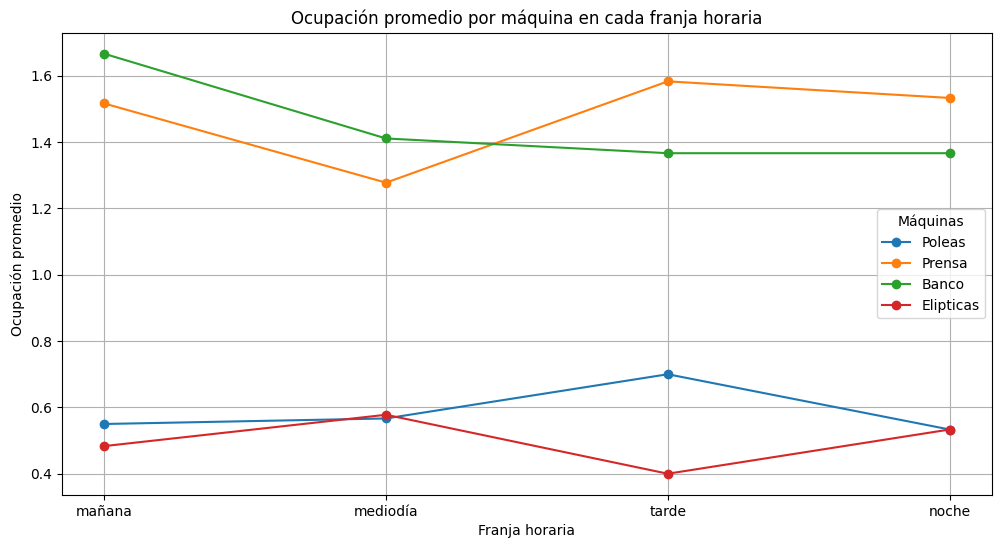

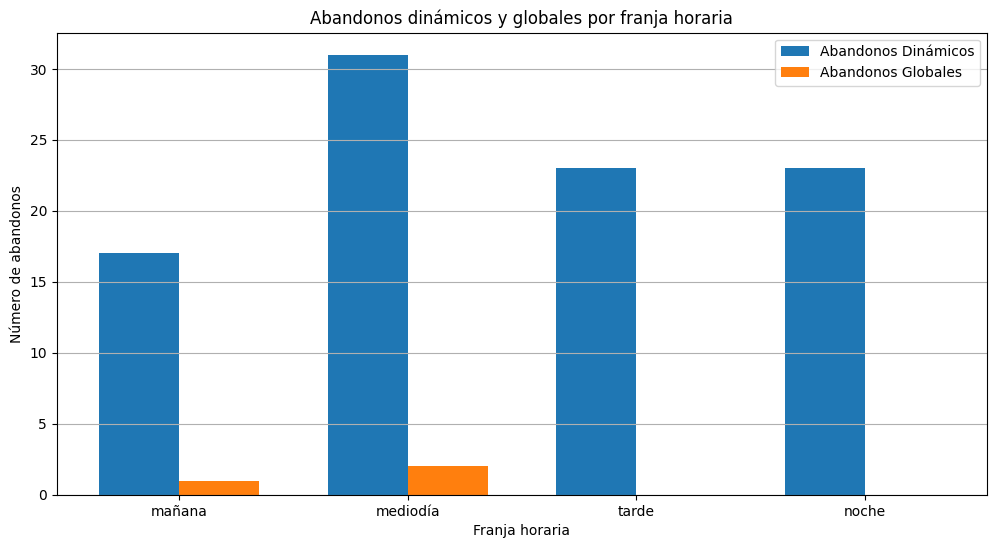

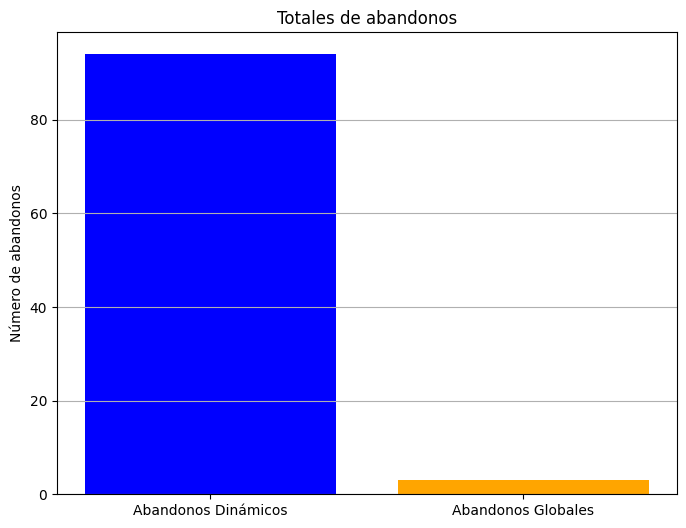

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Simulación previamente configurada (ajustar tu código antes de esto)

# Crear gráficas
def generar_graficas(resultados_por_franja, total_abandonos_dinamicos, total_abandonos_globales):
    # Datos para las gráficas
    franjas = list(resultados_por_franja.keys())
    maquinas = list(next(iter(resultados_por_franja.values()))["ocupacion"].keys())

    # --- Gráfica 1: Ocupación promedio por máquina en cada franja horaria ---
    plt.figure(figsize=(12, 6))
    for maquina in maquinas:
        ocupacion = [resultados_por_franja[franja]["ocupacion"][maquina] for franja in franjas]
        plt.plot(franjas, ocupacion, marker="o", label=maquina.capitalize())
    plt.title("Ocupación promedio por máquina en cada franja horaria")
    plt.xlabel("Franja horaria")
    plt.ylabel("Ocupación promedio")
    plt.legend(title="Máquinas")
    plt.grid()
    plt.show()

    # --- Gráfica 2: Abandonos dinámicos y globales por franja horaria ---
    abandonos_dinamicos = [resultados_por_franja[franja]["abandono_dinamico"] for franja in franjas]
    abandonos_globales = [resultados_por_franja[franja]["abandono_global"] for franja in franjas]

    x = np.arange(len(franjas))  # Posiciones para las barras
    width = 0.35  # Ancho de las barras

    plt.figure(figsize=(12, 6))
    plt.bar(x - width / 2, abandonos_dinamicos, width, label="Abandonos Dinámicos")
    plt.bar(x + width / 2, abandonos_globales, width, label="Abandonos Globales")
    plt.title("Abandonos dinámicos y globales por franja horaria")
    plt.xlabel("Franja horaria")
    plt.ylabel("Número de abandonos")
    plt.xticks(x, franjas)
    plt.legend()
    plt.grid(axis="y")
    plt.show()

    # --- Gráfica 3: Totales de abandonos ---
    labels = ["Abandonos Dinámicos", "Abandonos Globales"]
    valores = [total_abandonos_dinamicos, total_abandonos_globales]

    plt.figure(figsize=(8, 6))
    plt.bar(labels, valores, color=["blue", "orange"])
    plt.title("Totales de abandonos")
    plt.ylabel("Número de abandonos")
    plt.grid(axis="y")
    plt.show()


# Generar gráficas con los resultados de la simulación
generar_graficas(resultados_por_franja, total_abandonos_dinamicos, total_abandonos_globales)
